In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))

import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D as ax
import arrayfire as af

from dg_maxwell import params
from dg_maxwell import utils
from dg_maxwell import lagrange
from dg_maxwell import wave_equation_2d as w2d
from dg_maxwell import msh_parser
from dg_maxwell import isoparam

af.set_backend(params.backend)

gmshtranslator friendly reminder: rules and actions prototypes


def node_condition(tag,x,y,z,physgroups): 
def node_action(tag,x,y,z):
def element_condition(eletag,eletype,physgrp,nodes):
def element_action(eletag,eletype,physgrp,nodes):


/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1193: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)
/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1220: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)


In [2]:
N_LGL = 8
xi_LGL  = af.np_to_af_array(np.array(lagrange.LGL_points(N_LGL)))
eta_LGL = af.np_to_af_array(np.array(lagrange.LGL_points(N_LGL)))

eta = af.tile(eta_LGL, N_LGL)
xi = af.flat(af.transpose(af.tile(xi_LGL, 1, N_LGL)))

_, L_p = lagrange.lagrange_polynomials(xi_LGL)
_, L_q = lagrange.lagrange_polynomials(eta_LGL)

L_p = af.np_to_af_array(L_p)
L_q = af.np_to_af_array(L_q)

/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1193: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)
/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1220: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)


In [6]:
dLp_dxi  = utils.polynomial_derivative(L_p)
dLq_deta = utils.polynomial_derivative(L_q)

In [3]:
nodes, elements = msh_parser.read_order_2_msh('read_and_plot_mesh/mesh/square.msh')

gmshTranslator: Initializing...
gmshTranslator: Mesh has 49 nodes.
gmshTranslator: Mesh has 25 elements.
gmshTranslator: Processed 78 lines.
gmshTranslator: There are 1 physical groups available: 
gmshTranslator:      > 0
gmshTranslator: Parsing nodes
gmshTranslator: Parsing elements
gmshTranslator: No rules for elements... skipping elements.
gmshTranslator: Parsing nodes
gmshTranslator: No rules for nodes... skipping nodes.
gmshTranslator: Parsing elements


In [4]:
dxi_dx  = 1 / w2d.dx_dxi(nodes[elements[0]][:, 0], xi, eta)
dxi_dy  = 1 / w2d.dy_dxi(nodes[elements[0]][:, 1], xi, eta)
deta_dx = 1 / w2d.dx_deta(nodes[elements[0]][:, 0], xi, eta)
deta_dy = 1 / w2d.dy_deta(nodes[elements[0]][:, 1], xi, eta)

In [5]:
def F_xi(u):
    '''
    '''
    dxi_dx  = 1 / w2d.dx_dxi(nodes[elements[0]][:, 0], xi, eta)
    dxi_dy  = 1 / w2d.dy_dxi(nodes[elements[0]][:, 1], xi, eta)
    
    return w2d.F_x(u) * dxi_dx + w2d.F_y(u) * dxi_dy

def F_eta(u):
    '''
    '''
    deta_dx = 1 / w2d.dx_deta(nodes[elements[0]][:, 0], xi, eta)
    deta_dy = 1 / w2d.dy_deta(nodes[elements[0]][:, 1], xi, eta)    
    
    return w2d.F_x(u) * deta_dx + w2d.F_y(u) * deta_dy

gmshTranslator: Ending


In [7]:
def g_dd(x_nodes, y_nodes, xi, eta):
    '''
    '''
    ans00  =   (w2d.dx_dxi(x_nodes, xi, eta))**2 \
             + (w2d.dy_dxi(y_nodes, xi, eta))**2
    ans11  =   (w2d.dx_deta(x_nodes, xi, eta))**2 \
             + (w2d.dy_deta(y_nodes, xi, eta))**2
    
    ans01  =  (w2d.dx_dxi(x_nodes, xi, eta))  \
            * (w2d.dx_deta(x_nodes, xi, eta)) \
            + (w2d.dy_dxi(y_nodes, xi, eta))  \
            * (w2d.dy_deta(y_nodes, xi, eta))
    
    ans =  [[ans00, ans01],
            [ans01, ans11]
           ]
    
    return ans


def g_uu(x_nodes, y_nodes, xi, eta):
    gCov = g_dd(x_nodes, y_nodes, xi, eta)
    
    
    a = gCov[0][0]
    b = gCov[0][1]
    c = gCov[1][0]
    d = gCov[1][1]
    
    det = (a*d - b*c)
    
    ans = [[d / det, -b / det],
           [-c / det, a / det]]
    
    return ans


def sqrtgDet(x_nodes, y_nodes, xi, eta):
    '''
    '''
    gCov = g_dd(x_nodes, y_nodes, xi, eta)
    
    a = gCov[0][0]
    b = gCov[0][1]
    c = gCov[1][0]
    d = gCov[1][1]
    
    return (a*d - b*c)**0.5


In [8]:
print(g_uu(nodes[elements[0]][:, 0], nodes[elements[0]][:, 1], xi, eta))

[[arrayfire.Array()
Type: double
Dims: (64,), arrayfire.Array()
Type: double
Dims: (64,)], [arrayfire.Array()
Type: double
Dims: (64,), arrayfire.Array()
Type: double
Dims: (64,)]]


In [12]:
x = []
y = []

X = []
Y = []

u_init = []
u_init_mesh = []
for element in elements:
    x.append(af.np_to_af_array(isoparam.isoparam_x_2D(nodes[element][:, 0], Xi, Eta)))
    y.append(af.np_to_af_array(isoparam.isoparam_x_2D(nodes[element][:, 1], Xi, Eta)))

    X.append(af.np_to_af_array(isoparam.isoparam_x_2D(nodes[element][:, 0], Xi, Eta)))
    Y.append(af.np_to_af_array(isoparam.isoparam_x_2D(nodes[element][:, 1], Xi, Eta)))

    x[-1] = af.moddims(x[-1], d0 = N_LGL * N_LGL, d1 = 1)
    y[-1] = af.moddims(y[-1], d0 = N_LGL * N_LGL, d1 = 1)

    u_init.append(np.e ** (-(x[-1]**2 + y[-1]**2) / 0.4**2))
    u_init_mesh.append(af.moddims(u_init[-1], d0 = N_LGL, d1 = N_LGL))

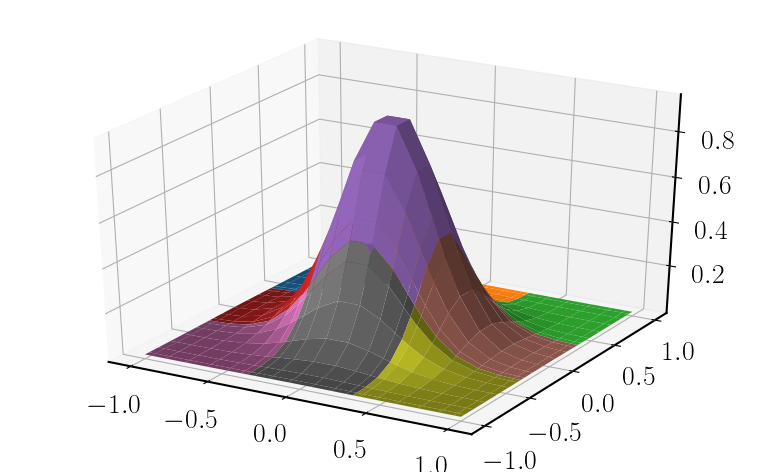

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for idx in np.arange(len(u_init_mesh)):
    ax.plot_surface(np.array(X[idx]), np.array(Y[idx]), np.array(u_init_mesh[idx]))

plt.show()

In [17]:
L_p      = utils.polyval_1d(L_p,      xi)
L_q      = utils.polyval_1d(L_q,      eta)
dLp_dxi  = utils.polyval_1d(dLp_dxi , xi)
dLq_deta = utils.polyval_1d(dLq_deta, eta)

In [ ]:
w_xi = lagrange.

In [26]:
foo = np.arange(4)
bar = np.arange(4)

foo, bar = np.meshgrid(foo, bar)
foo = af.np_to_af_array(foo)
bar = af.np_to_af_array(bar)

foo = af.moddims(foo, d0 = 4 * 4, d1 = 1)
bar = af.moddims(bar, d0 = 4 * 4, d1 = 1)

# print(foo)
# print(bar)

print(af.moddims(foo, d0 = 4, d1 = 4))
print(af.moddims(bar, d0 = 4, d1 = 4))


arrayfire.Array()
Type: long int

[4 4 1 1]
         0          1          2          3 
         0          1          2          3 
         0          1          2          3 
         0          1          2          3 


arrayfire.Array()
Type: long int

[4 4 1 1]
         0          0          0          0 
         1          1          1          1 
         2          2          2          2 
         3          3          3          3 


